The material in this tutorial is based on the data provided in the following paper:<br>Zou, J., Huss, M., Abid, A., Mohammadi, P., Torkamani, A. and Telenti, A., 2019. A primer on deep learning in genomics. Nature genetics, 51(1), pp.12-18. doi: https://doi.org/10.1038/s41588-018-0295-5.<br> and the associated GitHub repository: https://github.com/abidlabs/deep-learning-genomics-primer/tree/master

In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import itertools

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

import tensorflow as tf
import keras
from keras import utils
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Conv1D, MaxPooling1D, Flatten
import tensorflow.keras.backend as K

In [ ]:
keras.utils.set_random_seed(1) # Set random seed for reproducibility

In [ ]:
# Define classification metrics
def get_metrics(y_test, y_predicted):
   accuracy = accuracy_score(y_test, y_predicted)
   precision = precision_score(y_test, y_predicted, average='weighted')
   recall = recall_score(y_test, y_predicted, average='weighted')
   f1 = f1_score(y_test, y_predicted, average='weighted')
   return accuracy, precision, recall, f1

## Data Loading

In [ ]:
df = pd.read_csv('/content/drive/My Drive/ISMB 2024/tfbs/sequences.txt', sep=' ', header=None)
df.head(2)

,0
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...


In [ ]:
df_labels = pd.read_csv('/content/drive/My Drive/ISMB 2024/tfbs/labels.txt', sep=' ', header=None)
df_labels.head(2)

,0
0,0
1,0


In [ ]:
df['label'] = df_labels[0]
df = df.rename(columns={0: 'sequence'})
df.head(2)

,sequence,label
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0


## Data Pre-processing

In [ ]:
# One-hot encode the sequences

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()

# The OneHotEncoder converts an array of integers to a sparse matrix where each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []
sequences = df['sequence'].values

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

input_features = np.stack(input_features)

# Print an example to check
print('DNA sequence:\n',sequences[0])
print('One hot encoding of DNA sequence:\n',input_features[0].T)

DNA sequence:
 CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC
One hot encoding of DNA sequence:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1.
  0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
  1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [ ]:
# One-hot encode labels
one_hot_encoder = OneHotEncoder(categories='auto')
labels = df['label'].values
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

# Print to check
print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[0 0 0 ... 0 1 1]]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(input_features, input_labels, test_size=0.20, random_state=42)

## Simple RNN
In a Recurrent Neural Network (RNN), the input from the previous step is used as input for the current step. This works well for sequential data, e.g., text, where the next word depends on the context from previous words.<br>
See here for further explanation: https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/.

In [ ]:
model = Sequential()
# SimpleRNN: "Fully-connected RNN where the output is to be fed back as the new input."
# Keras documentation: https://keras.io/api/layers/recurrent_layers/simple_rnn/
model.add(SimpleRNN(10, input_shape=(X_train.shape[1], 4), activation='linear'))
# Dense output layer for binary classification. We have two neurons as we have one-hot encoded the labels.
# Keras documentation: https://keras.io/api/layers/core_layers/dense/
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.20)

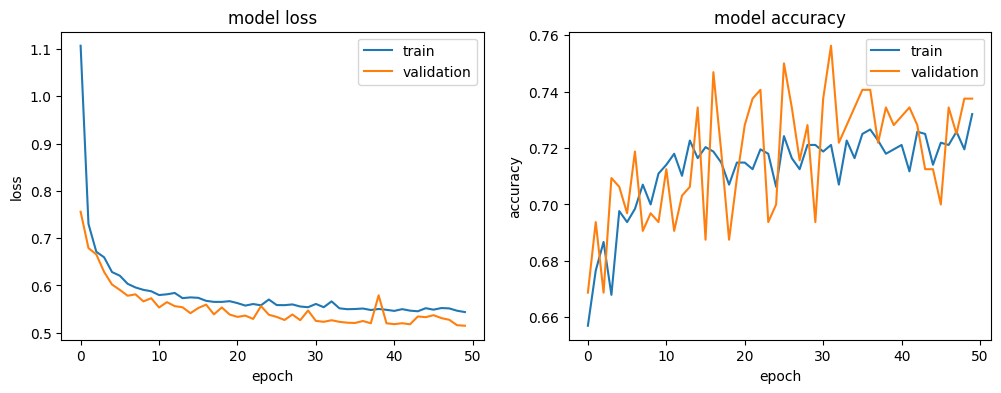

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Plot the training and validation loss for each epoch.
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'])
# Plot the training and validation accuracy for each epoch.
ax[1].plot(history.history['binary_accuracy'])
ax[1].plot(history.history['val_binary_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'])

plt.show()

In [ ]:
# Make a prediction for each sample in the test set
y_pred = model.predict(np.stack(X_test))

13/13 [==============================] - 0s 4ms/step


In [ ]:
print(y_pred[0:2])

[[0.0015949  0.99840516]
 [0.58619666 0.41380337]]


In [ ]:
# Use a decision threshold of 0.5
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
print(y_pred_binary[0:2])

[[0 1]
 [1 0]]


In [ ]:
# Calculate metrics
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_binary)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.760 
precision = 0.760 
recall = 0.760 
f1 = 0.760


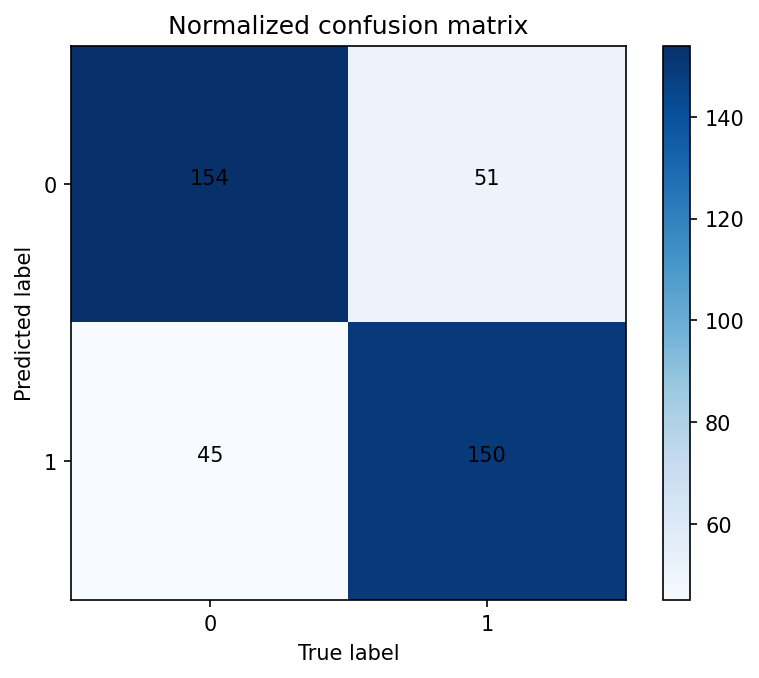

In [ ]:
# Plot a confusion matrix
# Predicted label = 1 & True label = 1 -> True positive
# Predicted label = 0 & True label = 0 -> True negative
# Predicted label = 1 & True label = 0 -> False positive
# Predicted label = 0 & True label = 1 -> False negative

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(dpi=150)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
             horizontalalignment='center',
             color='black')
plt.show()

## LSTM
Long Short-Term Memory (LSTM) is an extension of RNN, which avoids issues faced by traditional RNNs, such as [vanishing and exploding gradients](https://www.superdatascience.com/blogs/recurrent-neural-networks-rnn-the-vanishing-gradient-problem).<br>
See here for further explanation: https://www.geeksforgeeks.org/understanding-of-lstm-networks/.

In [ ]:
model = Sequential()
# Long Short-Term Memory layer
# Keras documentation: https://keras.io/api/layers/recurrent_layers/lstm/
model.add(LSTM(10, input_shape=(X_train.shape[1], 4), activation='linear'))
# Dense output layer for binary classification. We have two neurons as we have one-hot encoded the labels.
# Keras documentation: https://keras.io/api/layers/core_layers/dense/
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.20)

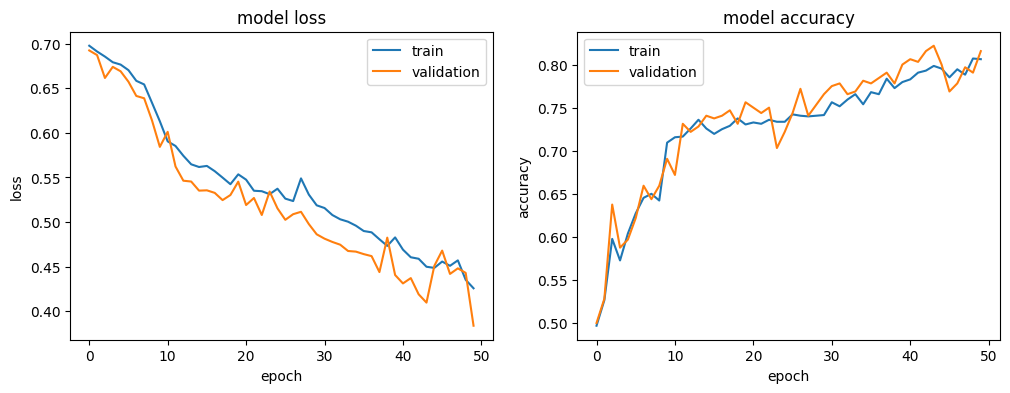

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Plot the training and validation loss for each epoch.
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'])
# Plot the training and validation accuracy for each epoch.
ax[1].plot(history.history['binary_accuracy'])
ax[1].plot(history.history['val_binary_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'])

plt.show()

In [ ]:
# Make a prediction for each sample in the test set
y_pred = model.predict(np.stack(X_test))
print(y_pred[0:2])

13/13 [==============================] - 0s 9ms/step
[[0.00265893 0.9973411 ]
 [0.37062347 0.6293764 ]]


In [ ]:
# Use a decision threshold of 0.5
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
print(y_pred_binary[0:2])

[[0 1]
 [0 1]]


In [ ]:
# Calculate metrics
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_binary)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.825 
precision = 0.829 
recall = 0.825 
f1 = 0.825


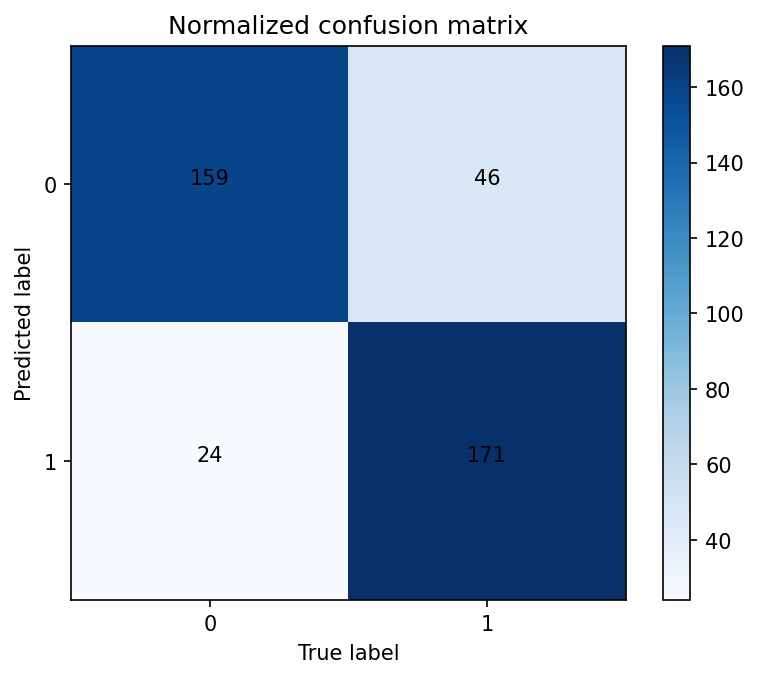

In [ ]:
# Plot a confusion matrix
# Predicted label = 1 & True label = 1 -> True positive
# Predicted label = 0 & True label = 0 -> True negative
# Predicted label = 1 & True label = 0 -> False positive
# Predicted label = 0 & True label = 1 -> False negative

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(dpi=150)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
             horizontalalignment='center',
             color='black')
plt.show()

## 1D CNN
A one-dimensional convolutional neural network (1D CNN) is another type of deep learning model. It uses the Conv1D layer to slide a convolutional filter across the input sequences in order to learn patterns.<br>
See here for further explanation: https://www.geeksforgeeks.org/what-is-a-1d-convolutional-layer-in-deep-learning/.


In [ ]:
print(X_train.shape)
print(y_train.shape)

(1600, 50, 4)
(1600, 2)


In [ ]:
model = Sequential()
# The Conv1D layer "creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs."
# Keras documentation: https://keras.io/api/layers/convolution_layers/convolution1d/
model.add(Conv1D(filters=8, kernel_size=12,
                 input_shape=(X_train.shape[1], 4)))
# The MaxPooling1D layer downsamples the input representation by taking the maximum value over a spatial window of size 4 (pool_size).
# Keras documentation: https://keras.io/api/layers/pooling_layers/max_pooling1d/
model.add(MaxPooling1D(pool_size=4))
# The Flatten layer flattens the input.
# Keras documentation: https://keras.io/api/layers/reshaping_layers/flatten/
model.add(Flatten())
# Dense output layer for binary classification. We have two neurons as we have one-hot encoded the labels.
# Keras documentation: https://keras.io/api/layers/core_layers/dense/
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 39, 8)             392       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 9, 8)              0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 146       
                                                                 
Total params: 538 (2.10 KB)
Trainable params: 538 (2.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.20)

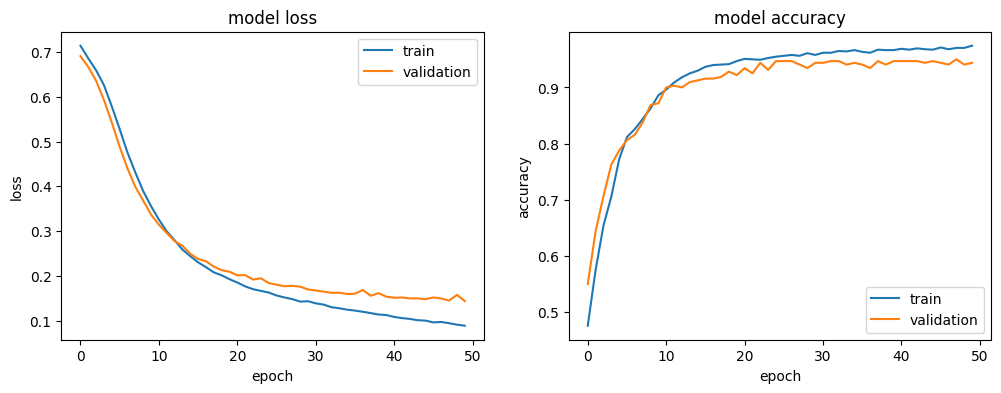

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# Plot the training and validation loss for each epoch.
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'])
# Plot the training and validation accuracy for each epoch.
ax[1].plot(history.history['binary_accuracy'])
ax[1].plot(history.history['val_binary_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'])

plt.show()

In [ ]:
# Make a prediction for each sample in the test set
y_pred = model.predict(np.stack(X_test))

13/13 [==============================] - 0s 3ms/step


In [ ]:
print(y_pred[0:2])

[[2.6101204e-06 9.9999732e-01]
 [9.9999994e-01 1.6138184e-08]]


In [ ]:
# Use a decision threshold of 0.5
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
print(y_pred_binary[0:2])

[[0 1]
 [1 0]]


In [ ]:
# Calculate metrics
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_binary)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.960 
precision = 0.960 
recall = 0.960 
f1 = 0.960


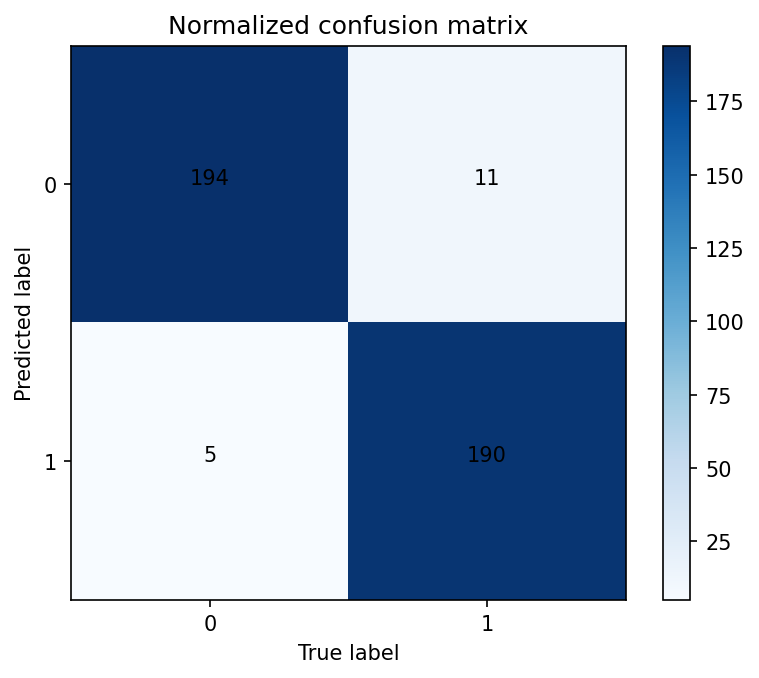

In [ ]:
# Plot a confusion matrix
# Predicted label = 1 & True label = 1 -> True positive
# Predicted label = 0 & True label = 0 -> True negative
# Predicted label = 1 & True label = 0 -> False positive
# Predicted label = 0 & True label = 1 -> False negative

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plt.figure(dpi=150)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),
             horizontalalignment='center',
             color='black')
plt.show()